<a href="https://colab.research.google.com/github/anthony4582/birdidtheword/blob/master/AI_VOD_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to try to assign sentiment (polarity) to the VOD report using Hugging Face NLTK models.


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import wordcloud
from wordcloud import STOPWORDS, WordCloud
import datetime as dt
import nltk
import numpy as np
from tqdm.notebook import tqdm


Import VOD file as csv

In [36]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [35]:
import io
VOD = pd.read_csv(io.BytesIO(uploaded['2023 VOD Report.csv']), dtype={"INTERACTION COMMENT":str})

# Dataset is now stored in a Pandas Dataframe
# set interaction date as datetime
VOD['INTERACTION DATE'] = pd.to_datetime(VOD['INTERACTION DATE'])

# set interaction comment as string
VOD['INTERACTION COMMENT'] = VOD['INTERACTION COMMENT'].astype(str)

print(VOD.info())

UnicodeDecodeError: ignored

In [56]:
VOD = VOD.rename(columns = {"INTERACTION COMMENT": "Comment","Interactions\Contact method":"contactmethod","INTERACTION DATE":"Date", "LOOKUP ID": "LOOKUP_ID"})

print(VOD.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   LOOKUP_ID                 149 non-null    int64         
 1   ID                        149 non-null    object        
 2   DONOR                     149 non-null    object        
 3   Sponsor\Sponsor since     38 non-null     object        
 4   Date                      149 non-null    datetime64[ns]
 5   Interactions\Category     149 non-null    object        
 6   Interactions\Subcategory  149 non-null    object        
 7   sentiment                 149 non-null    object        
 8   Comment                   149 non-null    object        
 9   INTERACTION ADDED BY      149 non-null    object        
 10  contactmethod             149 non-null    object        
 11  QUERYRECID                149 non-null    object        
dtypes: datetime64[ns](1), 

Run ROBERTA Model  - which is an AI driven model that understands words contextually rather than VADERS which scores a "bag of words" approach

In [57]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [58]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [59]:
#Sample ROBERTA model run

print(VOD['Comment'][0])

encoded_text = tokenizer(VOD['Comment'][0], return_tensors='pt')
result = model(**encoded_text)
ROBERTA_scores = result[0][0].detach().numpy()
ROBERTA_scores = softmax(ROBERTA_scores)

scores_dict= {
    'neg' : ROBERTA_scores[0],
    'neu' : ROBERTA_scores[1],
    'pos' : ROBERTA_scores[2]
}

print(scores_dict)

Donor suggested Applepay
{'neg': 0.022582756, 'neu': 0.71288466, 'pos': 0.26453257}


In [60]:
#Full dataset run with ROBERTA Model. Setting up a function to apply

def polarity_scores_roberta(x):
  encoded_text = tokenizer(x, return_tensors='pt')
  result = model(**encoded_text)
  ROBERTA_scores = result[0][0].detach().numpy()
  ROBERTA_scores = softmax(ROBERTA_scores)

  scores_dict= {
    'neg' : ROBERTA_scores[0],
    'neu' : ROBERTA_scores[1],
    'pos' : ROBERTA_scores[2]
  }
  return scores_dict

In [61]:
#Run polarity on entire dataset

results={}

for i, row in tqdm(VOD.iterrows(), total=len(VOD)):
  try:
    text=row['Comment']
    ID=row['ID']
    roberta_result = polarity_scores_roberta(text)
    results[ID] = roberta_result

  except RuntimeError:
    print(f'Failed for LookupID {ID}')
    results[ID] = {'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

  0%|          | 0/149 [00:00<?, ?it/s]

Failed for LookupID 94Nov


In [62]:
print(dict(list(results.items())[0:2]))

print(len(results))

{'2Nov': {'neg': 0.022582756, 'neu': 0.71288466, 'pos': 0.26453257}, '3Nov': {'neg': 0.49943694, 'neu': 0.44860974, 'pos': 0.051953297}}
149


In [63]:
#Samples

a = "This is awesome. I loved it so much"
b = "This was terrible. It wasn't up to my expectations."
c = "I didn't like the three edges but it worked fairly well enough"

print(polarity_scores_roberta(c))

{'neg': 0.09272907, 'neu': 0.37644804, 'pos': 0.5308229}


In [66]:
#Shifting results into dataframe for subsequent merging.
Roberti_scores = pd.DataFrame(results).T
print(type(Roberti_scores))
Roberti_scores.index.name = 'ID'
Roberti_scores['sentiment'] = Roberti_scores.idxmax(axis=1)
print(Roberti_scores.head())

<class 'pandas.core.frame.DataFrame'>
           neg       neu       pos sentiment
ID                                          
2Nov  0.022583  0.712885  0.264533       neu
3Nov  0.499437  0.448610  0.051953       neg
4Nov  0.534235  0.408497  0.057268       neg
5Nov  0.872166  0.115792  0.012042       neg
6Nov  0.935355  0.059947  0.004698       neg


In [67]:
#Merge dataframes

master_frame = pd.merge(VOD, Roberti_scores, on='ID', how='inner')
print(master_frame.head())

   LOOKUP_ID    ID               DONOR Sponsor\Sponsor since       Date  \
0  115052901  2Nov  Voice Of The Donor                   NaN 2023-11-01   
1  116856630  3Nov      Nader Alansari                   NaN 2023-11-01   
2  117595447  4Nov      Janice McNally             1/27/2018 2023-11-01   
3  116894948  5Nov       David Lanagan                   NaN 2023-11-01   
4  122936359  6Nov    Karyn Honigsfeld                   NaN 2023-11-01   

  Interactions\Category Interactions\Subcategory sentiment_x  \
0    Voice of the Donor                Financial         neu   
1    Voice of the Donor                Financial         neg   
2    Voice of the Donor                Financial         neg   
3    Voice of the Donor                  Service         neg   
4    Voice of the Donor            Solicitations         neg   

                                             Comment   INTERACTION ADDED BY  \
0                           Donor suggested Applepay     SAVECHILDREN\nmelo   
1  Don

In [68]:
#Keeping smaller dataframes for charting

phone_contact = VOD[(VOD.contactmethod=='Phone')]['Date'].value_counts()
email_contact = VOD[(VOD.contactmethod=='E-mail')]['Date'].value_counts()
mail_contact = VOD[(VOD.contactmethod=='Mail')]['Date'].value_counts()
all_contact = VOD['Date'].value_counts()
print(email_contact)

2023-11-10    7
2023-11-09    6
2023-11-22    5
2023-11-06    5
2023-11-08    4
2023-11-02    4
2023-11-15    4
2023-11-03    3
2023-11-07    3
2023-11-13    3
2023-11-29    3
2023-11-20    3
2023-11-14    2
2023-11-27    2
2023-11-30    2
2023-11-16    2
2023-11-21    1
2023-11-17    1
2023-11-01    1
Name: Date, dtype: int64


<Figure size 2500x2000 with 0 Axes>

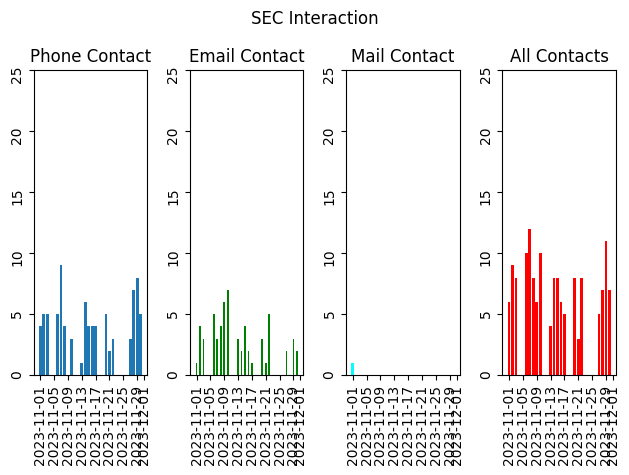

In [69]:
#Volume by inbound channel
plt.figure(figsize=(25,20))
fig, axs = plt.subplots(1,4, sharex=True)
x=90

axs[0].bar(phone_contact.index, phone_contact)
axs[0].set_title('Phone Contact')
axs[0].tick_params(labelrotation=x)
axs[0].set_ylim(0, 25)

axs[1].bar(email_contact.index, email_contact, color="green", width=0.5)
axs[1].set_title('Email Contact')
axs[1].tick_params(labelrotation=x)
axs[1].set_ylim(0, 25)

axs[2].bar(mail_contact.index,mail_contact, color='cyan')
axs[2].set_title('Mail Contact')
axs[2].tick_params(labelrotation=x)
axs[2].set_ylim(0, 25)

axs[3].bar(all_contact.index,all_contact, color='red')
axs[3].set_title('All Contacts')
axs[3].tick_params(labelrotation=x)
axs[3].set_ylim(0, 25)

plt.suptitle('SEC Interaction')
plt.tight_layout()
plt.show()
#a = phone_contact.index.strftime('%b %d, %y %a').sort_values()

<Figure size 1000x2000 with 0 Axes>

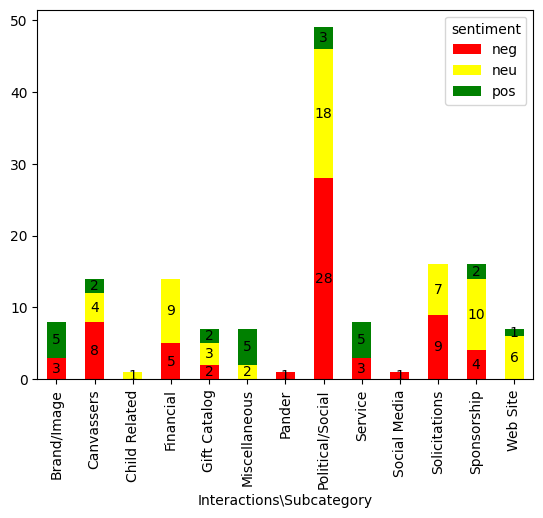

In [70]:
#Sentiment in nominal values
plt.figure(figsize=(10,20))
colors = {'neg': 'red', 'neu': 'yellow', 'pos': 'green'}

sentiment = (VOD
             .groupby('Interactions\Subcategory')['sentiment']
             .value_counts()
             .unstack()
             .fillna(0))

ax = sentiment.plot.bar(stacked=True, color=colors)
for c in ax.containers:
  labels = ["%d" % v.get_height() if v.get_height() > 0 else '' for v in c] #removes if label is too small
  ax.bar_label(c, labels=labels, label_type='center')

<Figure size 1000x3000 with 0 Axes>

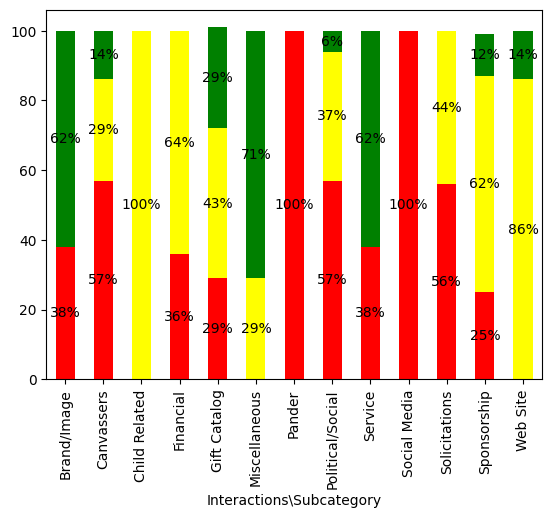

In [71]:
#Sentiment 100% stacked

#Sentiment
plt.figure(figsize=(10,30))
colors = {'neg': 'red', 'neu': 'yellow', 'pos': 'green'}

from matplotlib.ticker import FuncFormatter

formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)

s2 = (VOD
             .groupby('Interactions\Subcategory')['sentiment']
             .value_counts(normalize=True)
             .unstack()
             .fillna(0)
             .mul(100)
             .round()
             )

ax  = s2.plot.bar(stacked=True, color=colors)
ax.get_legend().remove()


for c in ax.containers:
  labels = ["%d%%" % v.get_height() if v.get_height() > 0 else '' for v in c] #removes if label is too small
  ax.bar_label(c, labels=labels, label_type='center')

In [23]:
# split the comments
word_list = []
for w in VOD['Comment']:
  word_list.append(w.split())


#count the frequency of words
word_count = {}
for x in word_list:
  for w in x:
    if w in word_count:
      word_count[w] += 1
    else:
      word_count[w] = 1

NameError: ignored

In [73]:
#create a function to order top N words
from collections import OrderedDict

def get_top_words(word_count, n=25, order=False):
    """Get top n words by frequency.

    Returns a dictionary or an `OrderedDict` if `order` is true.
    """
    top = sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:n]
    if order:
        return OrderedDict(top)
    return dict(top)

In [20]:
# creating list of words to remove to improve visibility
substrings_to_remove = ['org','savechildren','Subject','supportercare','savethechildren','organization', "donor", "the", "children", "501kingshighwayeast", "Donor", "STC", "I", "will", "Children", "We", "Save", "said","The","If",
                        "This","She","know","He","Us","-","time","wanted","donation","Please","You","us","information", "called","make","want","mail","received", "Your", "account", "one","note", "October", "use","go","sent","monthly",
                        "money","dear","please","asked","people","asked","people","Dear","Subject:", "work", "response", "donate", "2023", "organization.","donations","provide", "call", "Do","consider", "may", "stated", "It","stc", 'may',
                        'every', 'years', 'message', 'going', 'give', 'From', 'take', 'done', 'let','many', 'went','regarding', 'signed', 'put', 'ask', 'see', 'funds', 'get', 'say', 'told', 'gave', 'find', 'year','send', 'you.',
                        'Sent:', 'From:', 'To:','email', 'receive', 'name', 'november', 'mailing', 'November', 'Israel.']

#Adding preset list of words to remove
comment_words = ''
stopwords = set(STOPWORDS)

In [21]:
#Make a function to remove words and increase visibility. Pop here is used to remove words not a part of the builtin stop word list.

def wordpop(x):
  for key in x:
    word_count.pop(key, None)

In [22]:
wordpop(substrings_to_remove)
wordpop(stopwords)

get_top_words(word_count)

NameError: ignored

In [14]:
#Image outline

from PIL import Image
from os import path
# d = r'C:/Users/amacchia/Desktop/'
# momandchild_mask = np.array(Image.open(path.join(d, "MomandChild.PNG")))

from google.colab import files
uploaded = files.upload()

Saving MomandChild.PNG to MomandChild.PNG


In [15]:
MomandChild = np.array(Image.open('MomandChild.PNG'))

In [17]:
#iterate through the dictionary
for key in get_top_words(word_count):
  val = str(key)
  tokens = val.split()

  for i in range(len(tokens)):
    tokens[i]  = tokens[i].lower()
    comment_words += "".join(tokens)+" "

wordcloud = WordCloud(width=800, height=800,
                      background_color = 'white',
                      mask=MomandChild,
                      stopwords = stopwords,
                      contour_width=3,
                      contour_color='steelblue',
                      min_font_size = 10).generate(comment_words)

NameError: ignored

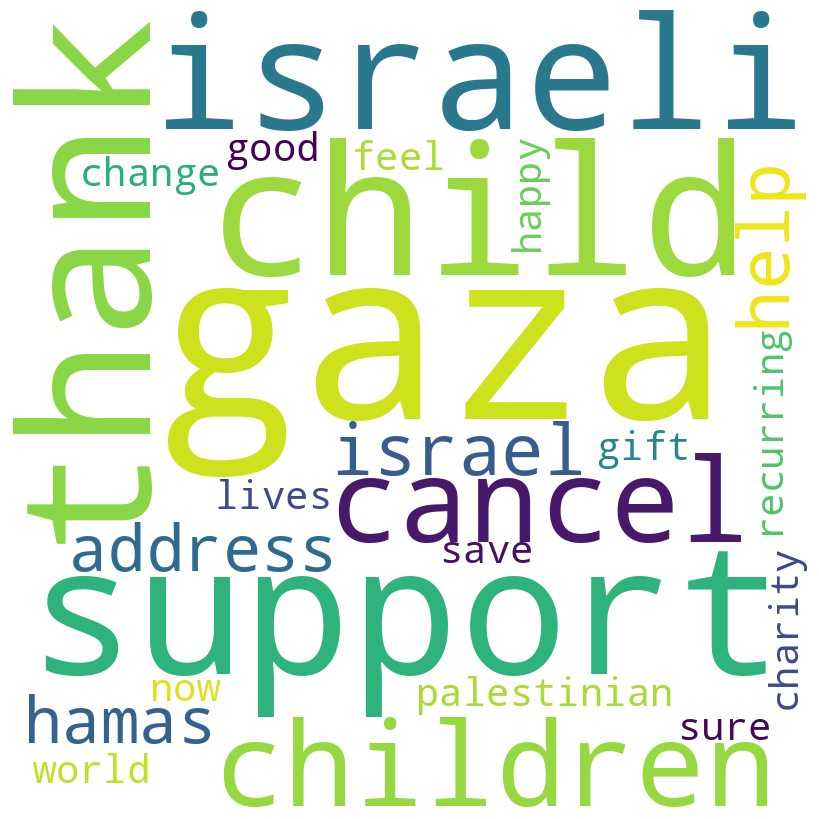

In [81]:
#plot the WordCloud image
plt.figure(figsize = (8,8), facecolor= "None")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [82]:
# s = VOD[VOD['Interactions\\Subcategory'] == 'Solicitations']
# s2 = s[s['sentiment']=='neg']
# print(s2)

# scored = pd.DataFrame(results).T
# scored.to_excel(excel_writer = r'C:\Users\amacchia\Desktop\scored.xlsx', sheet_name='scores')